In [118]:
import torch
import numpy as np
import utils.gradientUtils as gu
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

threshold = 1e-9
max_iter = 30000
learning_rate = 0.03
radius = 3
sdf = 'box'
#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))

destination = "./images/autograd/multiple_sites/"

Using device:  NVIDIA GeForce RTX 3090


In [119]:
torch.manual_seed(30)
sites = torch.rand(11, 2, dtype=torch.float32,device=device, requires_grad=True)
print(sites)


tensor([[0.2408, 0.1132],
        [0.1845, 0.1563],
        [0.3261, 0.1293],
        [0.7838, 0.3381],
        [0.5913, 0.4022],
        [0.3134, 0.2906],
        [0.0420, 0.5967],
        [0.6875, 0.9998],
        [0.2186, 0.2906],
        [0.7747, 0.5358],
        [0.7153, 0.8012]], device='cuda:0', requires_grad=True)


In [120]:
def get_delaunay_neighbors_list(sites):
    # Detach and convert to NumPy for Delaunay triangulation
    points_np = sites.detach().cpu().numpy()
    
    # Compute the Delaunay triangulation
    tri = Delaunay(points_np)

    # Find the neighbors of each point
    neighbors = {i: set() for i in range(len(points_np))}
    for simplex in tri.simplices:
        # Each simplex is a triangle of three points; each point is a neighbor of the other two
        for i in range(3):
            for j in range(i + 1, 3):
                neighbors[simplex[i]].add(simplex[j])
                neighbors[simplex[j]].add(simplex[i])

    # Convert neighbor sets to lists for easier reading
    neighbors = {key: list(value) for key, value in neighbors.items()}
    return neighbors


In [121]:
def compute_vertices_index(neighbors):
    vertices_index_to_compute = []
    for site, adjacents in neighbors.items():
        for i in adjacents:
            for n in adjacents:
                if n != site and n != i and n in neighbors[i]:              
                    vertices_index_to_compute.append([i,site,n])
            
    # Set to store the canonical (sorted) version of each triplet
    seen_triplets = set()
    # Filtered list to store the unique triplets
    filtered_triplets = []
    # Process each triplet and keep only one permutation
    for triplet in vertices_index_to_compute:
        # Convert the triplet to a canonical form by sorting it
        canonical_triplet = tuple(sorted(triplet, key=str))
        # Check if this canonical triplet has been seen before
        if canonical_triplet not in seen_triplets:
            # If not seen, add it to the set and keep the triplet
            seen_triplets.add(canonical_triplet)
            filtered_triplets.append(triplet)

    return filtered_triplets

In [122]:
import torch

# Define a function to compute the vertex coordinates
def compute_vertex(s_i, s_j, s_k):
    # Unpack coordinates for each site
    x_i, y_i = s_i[0], s_i[1]
    x_j, y_j = s_j[0], s_j[1]
    x_k, y_k = s_k[0], s_k[1]
    
    # Calculate numerator and denominator for x coordinate
    n_x = (
        x_i**2 * (y_j - y_k)
        - x_j**2 * (y_i - y_k)
        + (x_k**2 + (y_i - y_k) * (y_j - y_k)) * (y_i - y_j)
    )

    # Calculate numerator for y coordinate
    n_y = -(
        x_i**2 * (x_j - x_k)
        - x_i * (x_j**2 - x_k**2 + y_j**2 - y_k**2)
        + x_j**2 * x_k
        - x_j * (x_k**2 - y_i**2 + y_k**2)
        - x_k * (y_i**2 - y_j**2)
    )
    
    # Calculate denominator 
    d = 2 * (x_i * (y_j - y_k) - x_j * (y_i - y_k) + x_k * (y_i - y_j))
    
    # Calculate x and y coordinates
    x = n_x / d
    y = n_y / d

    # Return x, y as a tensor to maintain the computational graph
    return torch.stack([x, y])


In [123]:
def compute_all_vertices(sites, vertices_to_compute):
    # Initialize an empty tensor for storing vertices
    vertices = []
    
    for triplet in vertices_to_compute:
        si = sites[triplet[0]]
        sj = sites[triplet[1]]
        sk = sites[triplet[2]]
        
        # Compute vertex for the triplet (si, sj, sk)
        v = compute_vertex(si, sj, sk)  # Ensure compute_vertex is differentiable
        
        # Append to the list
        vertices.append(v)
    
    # Stack the list of vertices into a single tensor for easier gradient tracking
    vertices = torch.stack(vertices)
    return vertices


In [124]:
def circle_sdf_loss(vertices, radius=1.0):
    # Calculate the Euclidean distance of each vertex to the origin
    distances = torch.norm(vertices, dim=1)  # L2 norm along x and y for each vertex
    # Calculate the SDF value: distance to origin minus the circle radius
    sdf_values = distances - radius
    # Mean squared error loss for SDF
    loss = torch.mean(sdf_values**2)
    return loss

In [125]:
def box_sdf_loss(vertices, side_length=4.0):
    # Calculate half side length (since box is centered at origin)
    half_side = side_length / 2.0
    
    # Compute the signed distance to the box for each vertex
    dx = torch.clamp(torch.abs(vertices[:, 0]) - half_side, min=0)  # Distance from x-axis bounds
    dy = torch.clamp(torch.abs(vertices[:, 1]) - half_side, min=0)  # Distance from y-axis bounds
    
    # Calculate the SDF as the Euclidean distance from the nearest box boundary
    sdf_values = torch.sqrt(dx**2 + dy**2)
    
    # Mean squared error loss for the SDF values to minimize distance from box boundary
    loss = torch.mean(sdf_values**2)
    return loss


In [126]:
def autograd(sites, learning_rate=learning_rate, max_iter=max_iter, threshold=threshold, radius=radius):
    optimizer = torch.optim.Adam([sites], lr=learning_rate)
    prev_loss = float("inf")
    
    for epoch in range(max_iter):
        optimizer.zero_grad()
        
        #todo compute loss
        neighbors = get_delaunay_neighbors_list(sites)
        vertices_to_compute = compute_vertices_index(neighbors)
        vertices = compute_all_vertices(sites,vertices_to_compute)
        
        # Compute the SDF loss for vertices to the sdf
        if sdf == 'circle':
            loss = circle_sdf_loss(vertices, radius=radius)
        elif sdf == 'box':
            loss = box_sdf_loss(vertices)
        
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: loss = {loss.item()}")
        if abs(prev_loss - loss.item()) < threshold:
            break
        prev_loss = loss.item()
        
    return sites

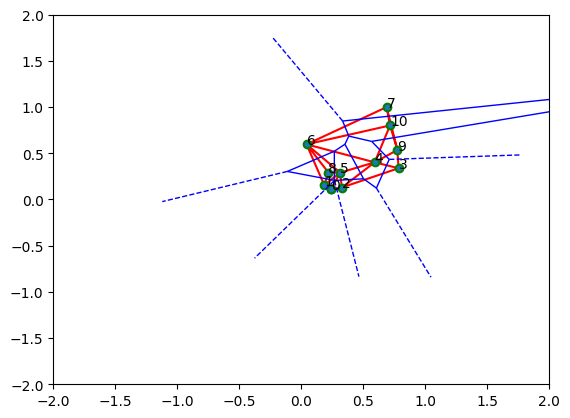

In [127]:

sites_np = sites.detach().cpu().numpy()
tri = Delaunay(sites_np)
voronoi_initial = Voronoi(sites_np)
fig, ax = plt.subplots()
voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
ax.triplot(sites_np[:, 0], sites_np[:, 1], tri.simplices, color='red')
plt.scatter(sites_np[0, 0], sites_np[0, 1], color='blue')
plt.scatter(sites_np[:, 0], sites_np[:, 1], color='green')

#annotate the points with their index
for i, txt in enumerate(range(len(sites_np))):
    ax.annotate(txt, (sites_np[i, 0], sites_np[i, 1]))

#scaled plot
plt.xlim(-2,2)
plt.ylim(-2,2)

plt.savefig(f'{destination}multiple_initial.png')

plt.show()

In [128]:
autograd(sites)

Epoch 0: loss = 0.0848589688539505


tensor([[0.2408, 0.1132],
        [0.1845, 0.1563],
        [0.3261, 0.1293],
        [0.7838, 0.3381],
        [0.5913, 0.4022],
        [0.3134, 0.2906],
        [0.0420, 0.5967],
        [0.7532, 1.0654],
        [0.2186, 0.2906],
        [0.8404, 0.6014],
        [0.6497, 0.7356]], device='cuda:0', requires_grad=True)

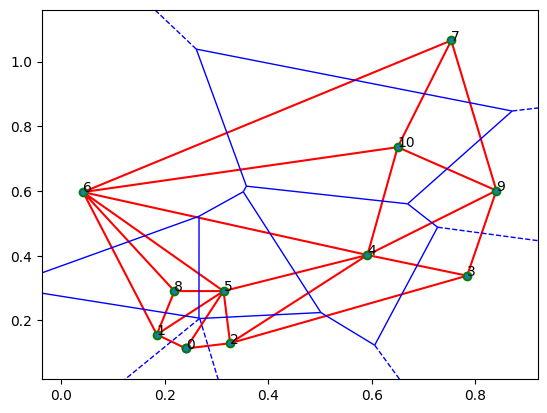

In [129]:

sites_np = sites.detach().cpu().numpy()
tri = Delaunay(sites_np)
voronoi_initial = Voronoi(sites_np)
fig, ax = plt.subplots()
voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
ax.triplot(sites_np[:, 0], sites_np[:, 1], tri.simplices, color='red')
plt.scatter(sites_np[0, 0], sites_np[0, 1], color='blue')
plt.scatter(sites_np[:, 0], sites_np[:, 1], color='green')

#annotate the points with their index
for i, txt in enumerate(range(len(sites_np))):
    ax.annotate(txt, (sites_np[i, 0], sites_np[i, 1]))


plt.savefig(f'{destination}multiple_'f'{sdf}_'f'{max_iter}.png')

plt.show()